<a href="https://colab.research.google.com/github/It21258794/DL_Assignment_SE4050/blob/main/Bidirectional_LSTM_Flight_Delay_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bidirectional LSTM Model **

In [ ]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional

In [ ]:
# Define the path to the data set
path = "/content/drive/MyDrive/flights_sample_3m.csv.zip"

In [ ]:
# importing the dataset
df = pd.read_csv(path)

# checking the dataset
df.head()

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,DIVERTED,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DELAY_DUE_CARRIER,DELAY_DUE_WEATHER,DELAY_DUE_NAS,DELAY_DUE_SECURITY,DELAY_DUE_LATE_AIRCRAFT
0,2019-01-09,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,1562,FLL,"Fort Lauderdale, FL",EWR,"Newark, NJ",...,0.0,186.0,176.0,153.0,1065.0,NaN,NaN,NaN,NaN,NaN
1,2022-11-19,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,1149,MSP,"Minneapolis, MN",SEA,"Seattle, WA",...,0.0,235.0,236.0,189.0,1399.0,NaN,NaN,NaN,NaN,NaN
2,2022-07-22,United Air Lines Inc.,United Air Lines Inc.: UA,UA,19977,459,DEN,"Denver, CO",MSP,"Minneapolis, MN",...,0.0,118.0,112.0,87.0,680.0,NaN,NaN,NaN,NaN,NaN
3,2023-03-06,Delta Air Lines Inc.,Delta Air Lines Inc.: DL,DL,19790,2295,MSP,"Minneapolis, MN",SFO,"San Francisco, CA",...,0.0,260.0,285.0,249.0,1589.0,0.0,0.0,24.0,0.0,0.0
4,2020-02-23,Spirit Air Lines,Spirit Air Lines: NK,NK,20416,407,MCO,"Orlando, FL",DFW,"Dallas/Fort Worth, TX",...,0.0,181.0,182.0,153.0,985.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
#remove the minus values
df = df[df['ARR_DELAY'] > 0]

In [ ]:
# show the shape of the dataset and the number of rows and columns
df.shape

(978147, 32)

In [ ]:
# check the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978147 entries, 3 to 2999997
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  978147 non-null  object 
 1   AIRLINE                  978147 non-null  object 
 2   AIRLINE_DOT              978147 non-null  object 
 3   AIRLINE_CODE             978147 non-null  object 
 4   DOT_CODE                 978147 non-null  int64  
 5   FL_NUMBER                978147 non-null  int64  
 6   ORIGIN                   978147 non-null  object 
 7   ORIGIN_CITY              978147 non-null  object 
 8   DEST                     978147 non-null  object 
 9   DEST_CITY                978147 non-null  object 
 10  CRS_DEP_TIME             978147 non-null  int64  
 11  DEP_TIME                 978147 non-null  float64
 12  DEP_DELAY                978147 non-null  float64
 13  TAXI_OUT                 978147 non-null  float64
 14  WHEELS_O

In [ ]:
#function for extract new hours and min from time features
def process_time_columns(df):
    # Convert 'hhmm' format into 'hours' and 'minutes' for both CRS_DEP_TIME and CRS_ARR_TIME
    df['CRS_DEP_HOUR'] = df['CRS_DEP_TIME'] // 100  # Extract hour part
    df['CRS_DEP_MINUTE'] = df['CRS_DEP_TIME'] % 100  # Extract minute part
    df['CRS_ARR_HOUR'] = df['CRS_ARR_TIME'] // 100  # Extract hour part
    df['CRS_ARR_MINUTE'] = df['CRS_ARR_TIME'] % 100  # Extract minute part

    # create a time period (morning, afternoon, etc.)
    df['DEP_TIME_PERIOD'] = pd.cut(df['CRS_DEP_HOUR'], bins=[0, 6, 12, 18, 24],
                                   labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
    return df

In [ ]:
#function for extract new features
def process_flight_data(df):
    df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], errors='coerce')  # Auto-infer format

    # Extract relevant date features
    df['DayOfWeek'] = df['FL_DATE'].dt.weekday  # 0=Monday, 6=Sunday
    df['IsWeekend'] = df['DayOfWeek'] >= 5  # True if weekend (Saturday/Sunday)

    # Process the time columns (CRS_DEP_TIME, CRS_ARR_TIME)
    df = process_time_columns(df)

    return df

In [ ]:
#function calling for process_flight_data
df = process_flight_data(df)

In [ ]:
#define arry of removing feature
columns_to_drop = [
    'CANCELLED',
    'CANCELLATION_CODE',
    'TAXI_OUT',
    'WHEELS_OFF',
    'WHEELS_ON',
    'TAXI_IN',
    'DELAY_DUE_CARRIER',
    'DELAY_DUE_WEATHER',
    'DELAY_DUE_NAS',
    'DELAY_DUE_SECURITY',
    'DELAY_DUE_LATE_AIRCRAFT',
    'DOT_CODE',
    'AIRLINE_CODE',
    'ORIGIN_CITY' ,
    'DEST_CITY',
    'AIRLINE_DOT',
    'FL_NUMBER',
    'DIVERTED',
    'FL_DATE'
]

In [ ]:
#drop the columns
df = df.drop(columns=columns_to_drop)
df.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
3,Delta Air Lines Inc.,MSP,SFO,1609,1608.0,-1.0,1829,1853.0,24.0,260.0,285.0,249.0,1589.0,0,False,16,9,18,29,Afternoon
5,Southwest Airlines Co.,DAL,OKC,1010,1237.0,147.0,1110,1331.0,141.0,60.0,54.0,36.0,181.0,2,False,10,10,11,10,Morning
7,Republic Airline,HSV,DCA,1643,1637.0,-6.0,1945,2008.0,23.0,122.0,151.0,88.0,613.0,0,False,16,43,19,45,Afternoon
9,Alaska Airlines Inc.,SEA,FAI,2125,2116.0,-9.0,2355,2356.0,1.0,210.0,220.0,198.0,1533.0,5,True,21,25,23,55,Evening
10,Delta Air Lines Inc.,ATL,BDL,1850,1959.0,69.0,2112,2212.0,60.0,142.0,133.0,115.0,859.0,4,False,18,50,21,12,Evening


In [ ]:
# encode the categorical data
le = LabelEncoder()

def clean_labels_encoder(list_of_labels, df):
    for label in list_of_labels:
        df[label] = le.fit_transform(df[label])
    return df

In [ ]:
# clean the labels
list_of_labels = ['AIRLINE','ORIGIN', 'DEST','DEP_TIME_PERIOD']
df = clean_labels_encoder(list_of_labels, df)

df.head()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
3,3,247,325,1609,1608.0,-1.0,1829,1853.0,24.0,260.0,285.0,249.0,1589.0,0,False,16,9,18,29,0
5,15,93,257,1010,1237.0,147.0,1110,1331.0,141.0,60.0,54.0,36.0,181.0,2,False,10,10,11,10,2
7,13,167,96,1643,1637.0,-6.0,1945,2008.0,23.0,122.0,151.0,88.0,613.0,0,False,16,43,19,45,0
9,0,323,125,2125,2116.0,-9.0,2355,2356.0,1.0,210.0,220.0,198.0,1533.0,5,True,21,25,23,55,1
10,3,23,31,1850,1959.0,69.0,2112,2212.0,60.0,142.0,133.0,115.0,859.0,4,False,18,50,21,12,1


In [ ]:
# describe the dataset
df.describe()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
count,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000,978147.000000
mean,9.530615,183.524097,186.591513,1411.763108,1440.902581,36.931103,1565.261504,1524.442156,39.747665,145.360531,148.176939,118.710199,841.694322,3.021145,13.842180,27.545092,15.356715,29.589974,0.963674
std,5.886613,100.892457,101.232137,475.337798,503.149780,77.575176,519.539724,587.409559,75.812905,72.272892,74.259836,72.024239,594.077475,1.997709,4.733295,18.097563,5.192272,17.597147,0.883510
min,0.000000,0.000000,0.000000,1.000000,1.000000,-42.000000,1.000000,1.000000,1.000000,18.000000,17.000000,8.000000,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,99.000000,99.000000,1025.000000,1040.000000,0.000000,1205.000000,1145.000000,6.000000,91.000000,94.000000,65.000000,404.000000,1.000000,10.000000,11.000000,12.000000,15.000000,0.000000
50%,12.000000,199.000000,199.000000,1435.000000,1458.000000,16.000000,1630.000000,1624.000000,17.000000,130.000000,133.000000,103.000000,700.000000,3.000000,14.000000,29.000000,16.000000,30.000000,1.000000
75%,15.000000,261.000000,271.000000,1812.000000,1843.000000,44.000000,2003.000000,2007.000000,43.000000,176.000000,181.000000,150.000000,1076.000000,5.000000,18.000000,44.000000,20.000000,45.000000,2.000000
max,17.000000,379.000000,379.000000,2359.000000,2400.000000,2966.000000,2400.000000,2400.000000,2934.000000,705.000000,739.000000,692.000000,5095.000000,6.000000,23.000000,59.000000,24.000000,59.000000,3.000000


In [ ]:
# fill the missing values with mean
df.fillna(df.mean(), inplace=True)

# show correlation
df.corr()

,AIRLINE,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,DayOfWeek,IsWeekend,CRS_DEP_HOUR,CRS_DEP_MINUTE,CRS_ARR_HOUR,CRS_ARR_MINUTE,DEP_TIME_PERIOD
AIRLINE,1.000000,0.024552,0.016327,0.033217,0.035462,0.001631,0.008635,0.013912,-0.011957,-0.113601,-0.124456,-0.108901,-0.105196,-0.005052,-0.000379,0.033630,-0.007108,0.009862,-0.036036,-0.024060
ORIGIN,0.024552,1.000000,0.000778,-0.039605,-0.037884,-0.004130,-0.013498,-0.000849,-0.001511,0.063415,0.064489,0.065068,0.082937,0.002259,0.003777,-0.039444,-0.008594,-0.013536,0.000896,0.012959
DEST,0.016327,0.000778,1.000000,0.022023,0.020187,-0.010087,0.015654,0.007947,-0.012328,0.088658,0.084249,0.095822,0.081149,0.003038,0.004358,0.021923,0.005054,0.015683,-0.000573,0.002435
CRS_DEP_TIME,0.033217,-0.039605,0.022023,1.000000,0.876257,0.077697,0.637594,0.352130,0.055199,-0.038768,-0.062554,-0.045352,-0.030150,0.011405,0.000350,0.999281,0.129775,0.637099,0.025952,-0.554952
DEP_TIME,0.035462,-0.037884,0.020187,0.876257,1.000000,0.099694,0.644623,0.424005,0.075177,-0.056315,-0.082219,-0.065539,-0.055079,0.009289,0.000566,0.875368,0.120506,0.644383,0.018541,-0.535614
DEP_DELAY,0.001631,-0.004130,-0.010087,0.077697,0.099694,1.000000,0.052843,-0.033660,0.976687,0.006929,-0.040728,-0.021955,-0.002727,0.010438,0.013836,0.077642,0.010043,0.052627,0.007328,-0.044985
CRS_ARR_TIME,0.008635,-0.013498,0.015654,0.637594,0.644623,0.052843,1.000000,0.651352,0.041715,-0.000933,-0.013532,-0.006450,-0.003491,0.006898,0.000536,0.636663,0.095114,0.999426,0.034692,-0.497509
ARR_TIME,0.013912,-0.000849,0.007947,0.352130,0.424005,-0.033660,0.651352,1.000000,-0.036653,-0.023020,-0.024673,-0.022926,-0.029125,0.001345,-0.001298,0.351459,0.056615,0.653032,-0.038016,-0.431099
ARR_DELAY,-0.011957,-0.001511,-0.012328,0.055199,0.075177,0.976687,0.041715,-0.036653,1.000000,0.008407,0.008832,-0.004805,-0.002039,0.008262,0.009687,0.055212,0.005789,0.041475,0.007808,-0.036177
CRS_ELAPSED_TIME,-0.113601,0.063415,0.088658,-0.038768,-0.056315,0.006929,-0.000933,-0.023020,0.008407,1.000000,0.974515,0.986894,0.982501,0.009186,0.015757,-0.038856,-0.001996,-0.001105,0.005083,0.050965


In [ ]:
# show the correlation in a plt figure

def show_correlation(df):
    plt.figure(figsize=(20, 10))
    sns.set(style='whitegrid', context='notebook')
    sns.heatmap(df.corr(), annot=True, square=False, cmap='coolwarm')
    plt.show()

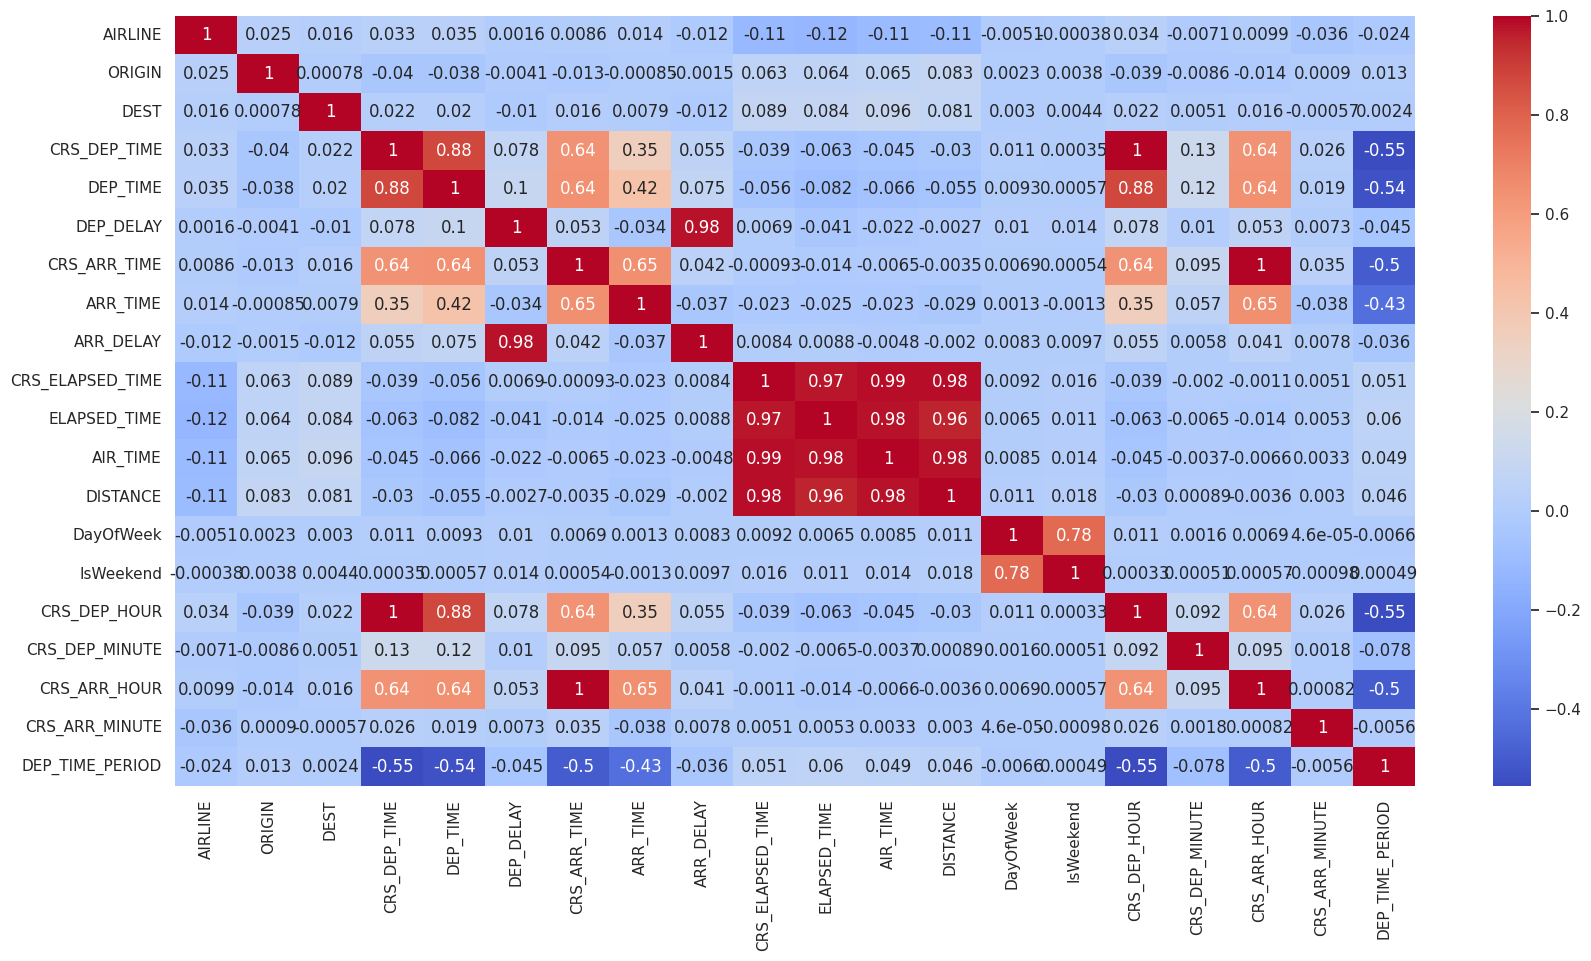

In [ ]:
# show the correlation
show_correlation(df)

In [ ]:
# split the data into features and target
# target is ARR_DELAY

X = df.drop(columns=['ARR_DELAY'])
y = df['ARR_DELAY']

In [ ]:
# Split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, shuffle=False)

In [ ]:
# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train = scaler_X.fit_transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

# Reshape y_train, y_val, and y_test into 2D arrays, scale them
y_train = y_train.values.reshape(-1, 1)  # Convert to numpy array and reshape
y_val = y_val.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

In [ ]:
# Reshape the data for input to the LSTM model
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Define the Bidirectional LSTM model architecture
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False, callbacks=[early_stopping])

Epoch 1/15
3745/3745 - 72s - 19ms/step - loss: 3.1762e-04 - mae: 0.0104 - val_loss: 2.1055e-05 - val_mae: 0.0033
Epoch 2/15
3745/3745 - 61s - 16ms/step - loss: 5.3072e-05 - mae: 0.0053 - val_loss: 6.2461e-06 - val_mae: 0.0016
Epoch 3/15
3745/3745 - 83s - 22ms/step - loss: 2.6025e-05 - mae: 0.0035 - val_loss: 1.7910e-06 - val_mae: 9.5711e-04
Epoch 4/15
3745/3745 - 61s - 16ms/step - loss: 1.5078e-05 - mae: 0.0025 - val_loss: 1.8958e-06 - val_mae: 0.0010
Epoch 5/15
3745/3745 - 82s - 22ms/step - loss: 1.0598e-05 - mae: 0.0019 - val_loss: 9.8908e-07 - val_mae: 5.5272e-04
Epoch 6/15
3745/3745 - 82s - 22ms/step - loss: 8.1069e-06 - mae: 0.0016 - val_loss: 9.6907e-07 - val_mae: 6.0888e-04
Epoch 7/15
3745/3745 - 81s - 22ms/step - loss: 6.9598e-06 - mae: 0.0014 - val_loss: 5.1112e-07 - val_mae: 3.6320e-04
Epoch 8/15
3745/3745 - 84s - 23ms/step - loss: 6.0126e-06 - mae: 0.0013 - val_loss: 2.2719e-07 - val_mae: 1.9653e-04
Epoch 9/15
3745/3745 - 80s - 21ms/step - loss: 5.9564e-06 - mae: 0.0012 - va

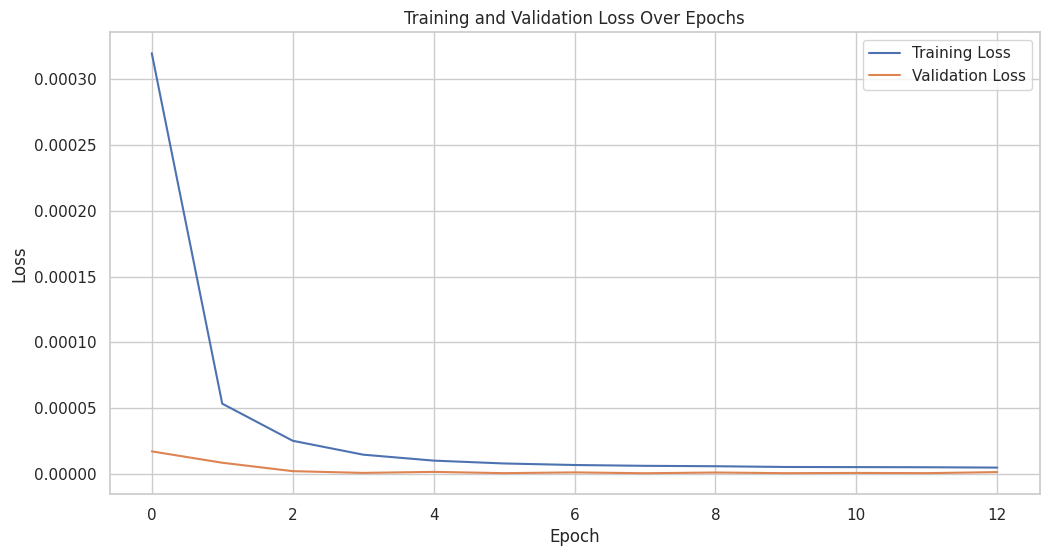

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss (MSE):', score[0])
print('Test MAE:', score[1])

Test loss (MSE): 2.2719267178672453e-07
Test MAE: 0.0001965334959095344


In [ ]:
# Predict and plot the results
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

9171/9171 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step


In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Calculate accuracy-like metric
accuracy = 100 - mape

print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {accuracy:.2f}%")

MAPE: 7.31%
Accuracy: 92.69%


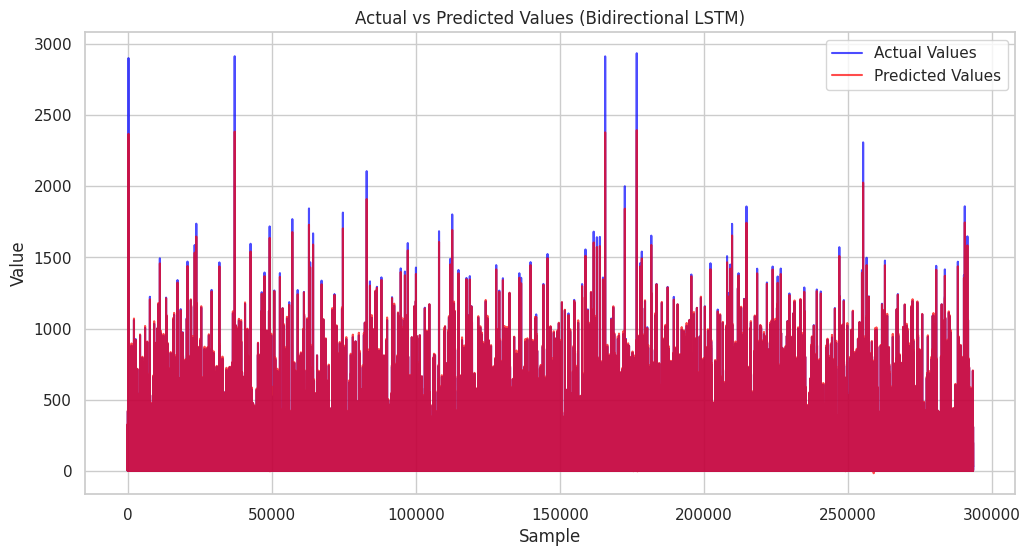

In [ ]:
# Plot predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Values', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Values', color='red', alpha=0.7)
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Bidirectional LSTM)')
plt.legend()
plt.show()